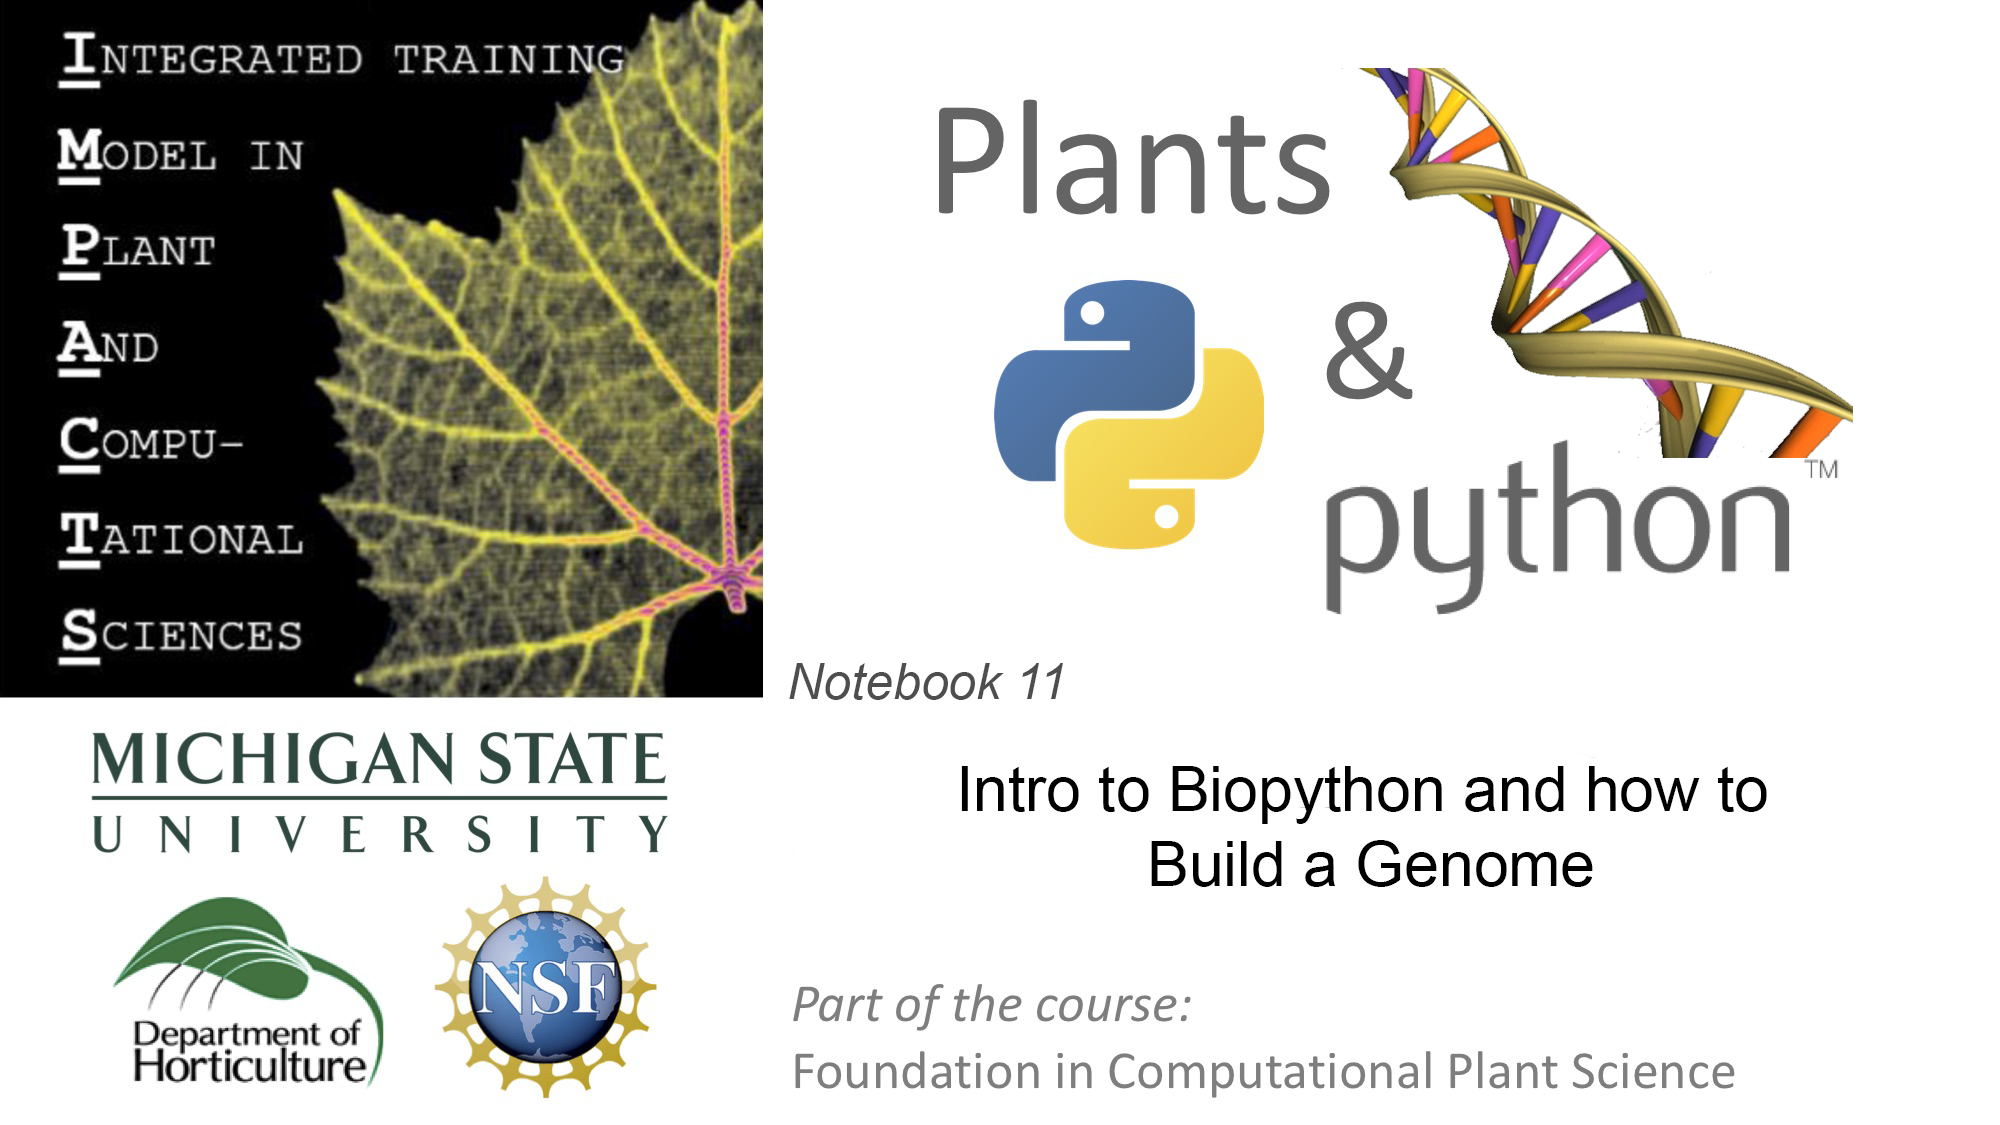

# An Introduction to Biopython and how to Build a Genome

In this set of notebooks, we will be analyzing large-scale biological datasets using leading programs and pipelines and writing our own Python scripts implemented in Jupyter. The scale of our data makes local computation on a laptop or desktop computer impossible, and we will be using the MSU High Performance Computer Cluster for most of our work. We will introduce new python libraries such as Biopython to analyze and manipulating biological datasets. We will also build off of our knowledge from Dan's portion of the course. The scope and scale of genomics projects is constantly expanding, and cutting-edge tools and algorithms are always changing to more efficiently and accurately draw meaning out of datasets. Here, we will use 'popular programs' as examples, but many other tools exist and others may be better suited for analyzing specific datasets. **Keep this in mind when designing and planning your final projects.**  At the end of this course, you should be able install, run, and troubleshoot almost any computational biology program, and write basic python scripts to reformat, transform, plot, or interpret data. We will make use of the vast wealth of previously published large-scale datasets on the NCBI Sequence Read Archive (SRA), Dryad, and Cyverse and conduct meta-analyses spanning species, treatments, developmental timecourses, and more to answer biological questions. In this lesson you will: (1) get a brief introduction to Biopython, (2) learn how to run genome assembly programs, (3) manipulate the output sequences, and (4) identify our unknown species. 

   # Pre-class activity: Basics of Biopython

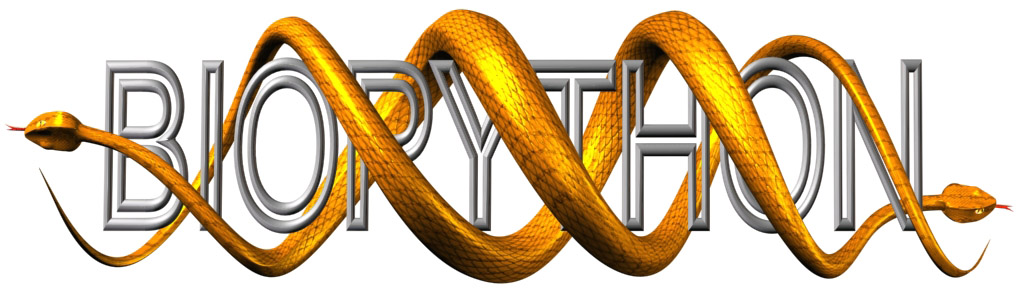

**Source of the materials**: Biopython Tutorial and Cookbook (adapted)

## (1) What is Biopython?

The Biopython Project is an international association of developers of freely available Python (http://www.python.org) tools for computational molecular biology. Python is an object oriented, interpreted, flexible language that is becoming increasingly popular for scientific computing. Python is easy to learn, has a very clear syntax and can easily be extended with modules written in C, C++ or FORTRAN.

The Biopython web site (http://www.biopython.org) provides an online resource for modules, scripts, and web links for developers of Python-based software for bioinformatics use and research. Basically, the goal of Biopython is to make it as easy as possible to use Python for bioinformatics by creating high-quality, reusable modules and classes. Biopython features include parsers for various Bioinformatics file formats (BLAST, Clustalw, FASTA, Genbank,...), access to online services (NCBI, Expasy,...), interfaces to common and not-so-common programs (Clustalw, DSSP, MSMS...), a standard sequence class, various clustering modules, a KD tree data structure etc. and even documentation.

You will need to install Biopython if you haven't already. To do this, type the following into the Anaconda powershell prompt: <br>
`pip install Biopython` <br>
You can check the basic installation and inspect the version by doing:

In [6]:
import Bio
print(Bio.__version__)

1.74


## Working with sequences


We’ll start with a quick introduction to the Biopython mechanisms for dealing with sequences, the Seq object, which we’ll discuss in more detail later.

Most of the time when we think about sequences we have in my mind a string of letters like ‘GATTACAGATTACA’. You can create such Seq object with this sequence as follows:

In [7]:
from Bio.Seq import Seq
my_seq = Seq("GATTACAGATTACA")
my_seq

Seq('GATTACAGATTACA')

In [8]:
print(my_seq)

GATTACAGATTACA


What we have here is a sequence object with a _generic_ alphabet - reflecting the fact we have _not_ specified if this is a DNA or protein sequence (thoguh, technically this could be a protein with a lot of Alanines, Glycines, Cysteines and Threonines!).

In addition to having an alphabet, the Seq object differs from the Python string in the methods it supports. You can’t do this with a plain string:

In [9]:
my_seq.complement()

Seq('CTAATGTCTAATGT')

In [10]:
my_seq.reverse_complement()

Seq('TGTAATCTGTAATC')

### **Sequences act like strings** 
In many ways, we can deal with Seq objects as if they were normal Python strings, for example getting the length, or iterating over the elements:

In [11]:
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import CodonTable

my_seq = Seq("GATTACAGATTACA", IUPAC.unambiguous_dna)
for index, letter in enumerate(my_seq):
    print("%i %s" % (index, letter))
print(len(my_seq))

0 G
1 A
2 T
3 T
4 A
5 C
6 A
7 G
8 A
9 T
10 T
11 A
12 C
13 A
14


You can access elements of the sequence in the same way as for strings (but remember, Python counts from zero!):

In [32]:
print(my_seq[0])
print(my_seq[2]) 
print(my_seq[-1])
my_seq[7:15] #take just a slice of the sequence. Genomes are big, maybe we just want a few characters

G
T
A


Seq('GATTACA', IUPACUnambiguousDNA())

You can also add sequences together:

In [34]:
my_seq = Seq('GATTACA', IUPAC.unambiguous_dna)
your_seq = Seq('GATTACA', IUPAC.unambiguous_dna)
my_seq + your_seq

Seq('GATTACAGATTACA', IUPACUnambiguousDNA())

Given these properties, we can figure out simple metrics such as GC content:

In [37]:
my_seq = Seq('GATTACAGATTACAGATTACAGATTACA', IUPAC.unambiguous_dna)
print(len(my_seq))
print(my_seq.count("G"))
print(100 * float(my_seq.count("G") + my_seq.count("C")) / len(my_seq))

28
4
28.571428571428573


While you could use the above snippet of code to calculate a GC\%, note that  the `Bio.SeqUtils` module has several GC functions already built.  For example:


In [12]:
from Bio.SeqUtils import GC
GC(my_seq)

28.571428571428573

We can also translate sequences from DNA or RNA to proteins: 

In [39]:
my_seq.translate()

Seq('DYRLQITDY', IUPACProtein())

'GATTACA' translates well (you should all see this movie), but other sequences aren't so lucky: 

In [42]:
my_bad_seq = Seq('GTACAGATGTAGTATACAGATTACAGATTACA', IUPAC.unambiguous_dna)
my_bad_seq.translate()

Seq('VQM*YTDYRL', HasStopCodon(IUPACProtein(), '*'))

## Reading Sequence Files
<br>
The workhorse function Bio.SeqIO.parse() is used to read in sequence data as SeqRecord objects.  This function expects two arguments:

* The first argument is a _handle_ to read the data from, or a filename. A handle is typically a file opened for reading, but could be the output from a command line program, or data downloaded from the internet.

* The second argument is a lower case string specifying sequence format -- we don't try and guess the file format for you!  See http://biopython.org/wiki/SeqIO for a full listing of supported formats. In this course, we will mostly use .fasta format

There is an optional argument alphabet to specify the alphabet to be used.  This is useful for file formats like FASTA where otherwise Bio.SeqIO will default to a generic alphabet.

The Bio.SeqIO.parse() function returns an _iterator_ which gives SeqRecord objects. Iterators are typically used in a for loop as shown below.

Sometimes you'll find yourself dealing with files which contain only a single record.  For this situation use the function Bio.SeqIO.read() which takes the same arguments.  Provided there is one and only one record in the file, this is returned as a SeqRecord object.  Otherwise an exception is raised. 
<br>
<br>
In general Bio.SeqIO.parse() is used to read in sequence files as SeqRecord objects, and is typically used with a for loop like this: <br>
**Note: make sure you have the sequences.txt file in the same path as your notebook. Or, list the full path.**

In [2]:
from Bio import SeqIO
for seq_record in list(SeqIO.parse("sequences.txt", "fasta")):
    
    print(seq_record.id) # prints sequence header
    print(repr(seq_record.seq)) # prints snipit of actual sequence
    print(len(seq_record)) # prints length of each sequence in the file

Ot_Chr10_26045
Seq('ATGGGTGAGCCTGATCCTGACGATGCGGTGCTCTTCGTTGCGGTCTCGCTGGTG...TGA', SingleLetterAlphabet())
3357
Ot_Chr10_26047
Seq('ATGGCTCGGCGGCCGCAGCCGGCGGTGGCGCCCCCCGCGCGGAAGGTCCCCCTC...TAA', SingleLetterAlphabet())
1494
Ot_Chr10_n30047
Seq('ATGGCTGATAAGGCGGATTGGGGTGATGTGTACTTGAGGCATTTGATTGATGTT...TAG', SingleLetterAlphabet())
595
Ot_Chr10_n30369
Seq('GCTGCTGCGGGCGGCGGCAGTGGCCCTGCTGCGTGCGCGGCGTGCAAGTTCCAG...TGA', SingleLetterAlphabet())
522
Ot_Un27_n40833
Seq('ATGGCTTCAAAACATGCACGGAGATTGGAAGGTGTAGTCCTATTACCCAAAATT...TAG', SingleLetterAlphabet())
2259
Ot_Un27_26314
Seq('ATGATCTCTGGGAGAACCATCTACCATGTTCTTGAAGAAACAGTGCCCTTATAT...TAA', SingleLetterAlphabet())
1122
Ot_Un27_27313
Seq('ATGGGTCCCGGCCTGTACTCCGACATCGGCAAGAAGGCGAGGGATCTCCTGTAT...TGA', SingleLetterAlphabet())
828


## Sequence files as dictionaries
<br>
<br>
The next thing that we'll do with our sequence files is to show how
to index them and access them like a database using the Python dictionary
data type. This is very useful for moderately large files
where you only need to access certain elements of the file, and makes for a nice
quick 'n dirty database.

You can use the function `Bio.SeqIO.to_dict()` to make a SeqRecord dictionary
(in memory).  By default this will use each record's identifier (i.e. the .id
attribute) as the key.  Let's try this:

In [4]:
grass_dict = SeqIO.to_dict(SeqIO.parse("sequences.txt", "fasta"))
print(len(grass_dict))
print(grass_dict.keys())

7
dict_keys(['Ot_Chr10_26045', 'Ot_Chr10_26047', 'Ot_Chr10_n30047', 'Ot_Chr10_n30369', 'Ot_Un27_n40833', 'Ot_Un27_26314', 'Ot_Un27_27313'])


We can access a single entry from the dictionary. This may be trivial with our 7 sequence file, but it is massively helpful in a ~30,000 sequence file:

In [5]:
seq_record = grass_dict["Ot_Chr10_26045"]
print(seq_record.description)
print(repr(seq_record.seq))
print(len(seq_record.seq))

Ot_Chr10_26045
Seq('ATGGGTGAGCCTGATCCTGACGATGCGGTGCTCTTCGTTGCGGTCTCGCTGGTG...TGA', SingleLetterAlphabet())
3357


## Writing sequence files
We've talked about using `Bio.SeqIO.parse()` for sequence input (reading files), and now we'll look at `Bio.SeqIO.write(`) which is for sequence output (writing files).  This is a function taking three arguments: some SeqRecord objects, a handle or filename to write to, and a sequence format. Maybe we want to take a single sequence from our multi sequence file and write a new file:

In [6]:
single_grass_gene = grass_dict["Ot_Chr10_26045"]
SeqIO.write(single_grass_gene, "grass_gene.fa", "fasta")

1

Maybe we want to keep all of our sequences but sort them by length. This can be done pretty easily with the `.sort` function

In [7]:
from Bio import SeqIO
records = list(SeqIO.parse("sequences.txt", "fasta"))
records.sort(key=lambda r: len(r))
SeqIO.write(records, "sequences_sorted.txt", "fasta")

#Lets check to make sure they're  sorted
for seq_record in list(SeqIO.parse("sequences_sorted.txt", "fasta")):
    print(seq_record.id) # prints sequence header
    print(len(seq_record)) # prints length of each sequence in the file


Ot_Chr10_n30369
522
Ot_Chr10_n30047
595
Ot_Un27_27313
828
Ot_Un27_26314
1122
Ot_Chr10_26047
1494
Ot_Un27_n40833
2259
Ot_Chr10_26045
3357


Lets say we want to sort it the opposite way:

In [8]:
from Bio import SeqIO
records = list(SeqIO.parse("sequences.txt", "fasta"))
records.sort(key=lambda r: -len(r))
SeqIO.write(records, "sequences_sorted.txt", "fasta")

#Lets check to make sure they're  sorted
for seq_record in list(SeqIO.parse("sequences_sorted.txt", "fasta")):
    print(seq_record.id) # prints sequence header
    print(len(seq_record)) # prints length of each sequence in the file


Ot_Chr10_26045
3357
Ot_Un27_n40833
2259
Ot_Chr10_26047
1494
Ot_Un27_26314
1122
Ot_Un27_27313
828
Ot_Chr10_n30047
595
Ot_Chr10_n30369
522


___

# In Class Activities: BLAST and Genome Assembly

# Running BLAST over the Internet


We use the function `qblast()` in the `Bio.Blast.NCBIWWW` module to call
the online version of BLAST. This has three non-optional arguments:

-   The first argument is the blast program to use for the search, as a
    lower case string. The options and descriptions of the programs are
    available at
    <http://www.ncbi.nlm.nih.gov/BLAST/blast_program.shtml>. Currently
    `qblast` only works with blastn, blastp, blastx, tblast and tblastx.

-   The second argument specifies the databases to search against.
    Again, the options for this are available on the NCBI web pages at
    <http://www.ncbi.nlm.nih.gov/BLAST/blast_databases.shtml>.

-   The third argument is a string containing your query sequence. This
    can either be the sequence itself, the sequence in fasta format, or
    an identifier like a GI number.

The `qblast` function also take a number of other option arguments which
are basically analogous to the different parameters you can set on the
BLAST web page. We’ll just highlight a few of them here:

-   The `qblast` function can return the BLAST results in various
    formats, which you can choose with the optional `format_type`
    keyword: `"HTML"`, `"Text"`, `"ASN.1"`, or `"XML"`. The default is
    `"XML"`.

-   The argument `expect` sets the expectation or e-value threshold.

For more about the optional BLAST arguments, we refer you to the NCBI’s
own documentation, or that built into Biopython:

In [9]:
from Bio.Blast import NCBIWWW
help(NCBIWWW.qblast)

Help on function qblast in module Bio.Blast.NCBIWWW:

qblast(program, database, sequence, url_base='https://blast.ncbi.nlm.nih.gov/Blast.cgi', auto_format=None, composition_based_statistics=None, db_genetic_code=None, endpoints=None, entrez_query='(none)', expect=10.0, filter=None, gapcosts=None, genetic_code=None, hitlist_size=50, i_thresh=None, layout=None, lcase_mask=None, matrix_name=None, nucl_penalty=None, nucl_reward=None, other_advanced=None, perc_ident=None, phi_pattern=None, query_file=None, query_believe_defline=None, query_from=None, query_to=None, searchsp_eff=None, service=None, threshold=None, ungapped_alignment=None, word_size=None, short_query=None, alignments=500, alignment_view=None, descriptions=500, entrez_links_new_window=None, expect_low=None, expect_high=None, format_entrez_query=None, format_object=None, format_type='XML', ncbi_gi=None, results_file=None, show_overview=None, megablast=None, template_type=None, template_length=None)
    BLAST search using NCBI's

Lets try BLASTing the previous file we wrote (grass_gene.fa) and see if we can figure out what species this gene came from! We can get fancy, but this logic is applied to all sorts of analyses and comparisons.  <br>
We will use `SeqIO.read` to read our fasta sequence and `NCBIWWW.qblast` to BLAST our sequence to all of the sequences in NCBI. Note: you must be connected to the internet for this to work. You can run local BLAST as well, but that is for another lesson. 
We will use `"blastn"` and `"nt"` because both the subject and query are nucleotide files, and we will set the output format type to `.text` so it is easier for us to read by eye. We can change other parameters as well, but default is fine for our purposes. 
<br>
**Note:** This may take a few minutes, depending on how busy the BLAST servers are and how many sequences you are BLASTing at a time. 

In [10]:
from Bio.Blast import NCBIWWW
query = SeqIO.read("grass_gene.fa", format="fasta")
result_handle = NCBIWWW.qblast("blastn", "nt", query.seq, format_type="Text")

We need to be a bit careful since we can use `result_handle.read()` to
read the BLAST output only once – calling `result_handle.read()` again
returns an empty string. After doing this, the results are in the file `my_blast.txt` and the
original handle has had all its data extracted (so we closed it).

In [11]:
with open("my_blast.txt", "w") as save_to:
    save_to.write(result_handle.read())
    result_handle.close()

Now that we have sucessfully saved our output, lets use a loop to read the file. What species are these sequences from? 

In [12]:
myfile = open("my_blast.txt")
for line in myfile:
    print(line)
myfile.close()


<p><!--

QBlastInfoBegin

	Status=READY

QBlastInfoEnd

--><p>

<PRE>

BLASTN 2.10.0+

Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro

A. Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and

David J. Lipman (1997), "Gapped BLAST and PSI-BLAST: a new

generation of protein database search programs", Nucleic

Acids Res. 25:3389-3402.





RID: UVFJX12U01R





Database: Nucleotide collection (nt)

           56,496,701 sequences; 253,942,268,922 total letters

Query= 

Length=3357





                                                                   Score     E     Max

Sequences producing significant alignments:                       (Bits)  Value  Ident



GU480079.1 Distichlis spicata plasma membrane Na+/H+ transport...  4874    0.0    92%         

AB244217.1 Phragmites australis PhaNHA1-n mRNA for Na+/H+ anti...  4241    0.0    88%         

AB244216.1 Phragmites australis PhaNHA1-u mRNA for Na+/H+ anti...  4241    0.0    88%         

AB244218.1 Phragmites austral


Query  2281  GTAGTGAAGTGGGCAAGTCAGAGACTAAGCAGCAGGCATTCCTTGGATCCAATTTTATCA  2340

             ||||| |||||| ||||||||||| |||||||||||||||| ||||||||||||||||||

Sbjct  2293  GTAGTAAAGTGGACAAGTCAGAGATTAAGCAGCAGGCATTCATTGGATCCAATTTTATCA  2352



Query  2341  CACGGAAACACTTTGGGTTTATACGAGGTGCTGATTGGAAAGCCATATATTTGTGATATG  2400

             || || | |||||||||  | || ||||||||||||||||| || ||||| ||||| |||

Sbjct  2353  CATGGCAGCACTTTGGGCCTGTATGAGGTGCTGATTGGAAAACCTTATATCTGTGACATG  2412



Query  2401  ATTACAGATTCTGTGGTGCATTGTTTCTTTGTAGAAGCTGAAAAGATTGAGCAACTTCGT  2460

             |||||||||||||||||||| || |||||  | |||||||||||||| |||||| | |||

Sbjct  2413  ATTACAGATTCTGTGGTGCACTGCTTCTTCATTGAAGCTGAAAAGATAGAGCAATTGCGT  2472



Query  2461  CAATCGGATCCTTCTATTGAGGTTTTCCTGTGGCAGGAAAGCTCCCTAGTTATTGCCAGG  2520

             ||||| ||||||||||||||| |||| ||||||||||||||  | |||||  ||||||||

Sbjct  2473  CAATCAGATCCTTCTATTGAGATTTTTCTGTGGCAGGAAAGTGCTCTAGTCGTTGCCAGG  2532



Query  2521  CTTTTACTTCCTCAGATATTTGAGAAAATG

Sbjct  2173  ATGCCAAGAATTAGCGAACTTCTAAACACCCATCCTTTAGTTGGTGCACTGCCTGCTGCT  2232



Query  2173  ACACGTGATCCTTTATTAAGTAATACAAAAGAAACTGTACGAGGGCATGGTACGATTCTT  2232

              | |||||||| ||||||||||||||||||||| |  ||  ||  ||||| ||||| |||

Sbjct  2233  GCTCGTGATCCGTTATTAAGTAATACAAAAGAATCAATAAAAGTACATGGAACGATCCTT  2292



Query  2233  TATAAGGAAGGCTCAAGGCCCACTGGTGTATGGCTTGTTTCAATAGGTGTAGTGAAGTGG  2292

             || |  |||||||||||||| |||||| ||||||||||||| |  ||  | || ||||||

Sbjct  2293  TACAGAGAAGGCTCAAGGCCGACTGGTATATGGCTTGTTTCGACTGGAATTGTAAAGTGG  2352



Query  2293  GCAAGTCAGAGACTAAGCAGCAGGCATTCCTTGGATCCAATTTTATCACACGGAAACACT  2352

              ||||||||||||| |||| |||||||||  |||||||||| || ||||| ||||  |||

Sbjct  2353  ACAAGTCAGAGACTCAGCACCAGGCATTCACTGGATCCAATATTGTCACATGGAAGTACT  2412



Query  2353  TTGGGTTTATACGAGGTGCTGATTGGAAAGCCATATATTTGTGATATGATTACAGATTCT  2412

             |||||| |||||||||   | ||||||||||||||||||||||| || |||||||| || 

Sbjct  2413  TTGGGTCTATACGAGGCATTAATTGGAAAGC

              |||| ||||| |||||| |||| |||||| | |||||| || || | ||||||||||||

Sbjct  1384  ATTGTTTGGTCTGGGCTGCGAGGTGCTGTTTCCCTATCATTAGCACTGTCTGTTAAACGT  1443



Query  1153  ACAAGTGATGCAGTCCAAACTTATCTGGAACCAGAAGTTGGAACAATGTTTGTGTTCTTC  1212

              | |||||| |||  ||| ||| |||| |||||||||| |||||||||||||||||||||

Sbjct  1444  GCTAGTGATACAGCTCAACCTTTTCTGAAACCAGAAGTGGGAACAATGTTTGTGTTCTTC  1503



Query  1213  ACTGGTGGCATTGTGTTTCTGACATTGATTGTAAATGGTTCAACCACACAATTTTTCTTA  1272

             ||||||||||| |||||||||||  ||||  | |||||||| |||||||||||||| || 

Sbjct  1504  ACTGGTGGCATCGTGTTTCTGACCCTGATATTGAATGGTTCTACCACACAATTTTTGTTG  1563



Query  1273  CATATGCTTGGCATGGACAAACTGTCAGCAACAAAGGTTCGGATATTGAAATATACAAGA  1332

             ||    ||||| |||||||| ||||||| ||||||| |||| || | ||| ||| | |||

Sbjct  1564  CACGCACTTGGTATGGACAACCTGTCAGTAACAAAGCTTCGCATGTCGAATTATGCTAGA  1623



Query  1333  CATGAAATGCTGAACAAAGCATTAGAGGCTTTTGGTGAGCTTAGGGATGATGAAGAGCTT  1392

             |||||||| || |||||  ||||||| ||||

Notice we don't have a 100% match. That's because this species (_Oropetium thomeaum_) is not on NCBI! _In my defense, they make it impossibly difficult to upload genome annotations to NCBI._ 

___

## Assembling a genome

Assembling a genome requires significant computational resources. It would take months or years to assemble a human (or maize) sized genome on your local computer, which would make for a long PhD! We can use the memory and CPU resources at the HPCC to reduce assembly time to a few minutes or a few days depending on the size of the genome and the amount of data being assembled. Like most computational tasks, there are a range of programs we can use to correct and assemble long read data, and each program has unique advantages and disadvantages. Some programs are better suited for assembling complex, polyploid, repetitive, or heterozygotic genomes but this often comes at a cost in terms of memory, CPUs, or assembly contiguity. Most genome assembly programs were developed and optimized for human or other ‘simple’ mammalian genomes, and they struggle to do a good job overcoming the complexity found in most plant genomes. We won’t go into details of algorithm design and implementation, but most assembly programs use a common framework of correcting the longest reads through aligning against shorter reads and then overlapping long reads to build a consensus sequence. 

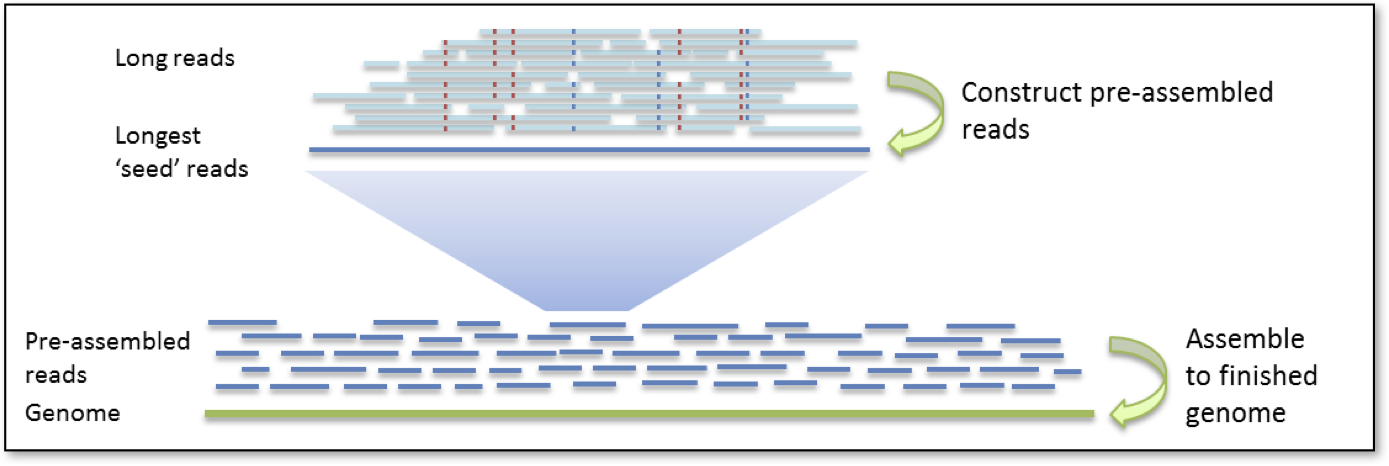

In this exercise, we will use Wtdbg2, a relatively new genome assembler that runs ~10 fold faster than the leading assemblers FALCON and CANU. This will allow us to assemble a high-quality genome in just a few minutes. Wtdbg2 is a _de novo_ sequence assembler for long noisy reads produced by PacBio or Oxford Nanopore Technologies. It assembles raw reads without error correction and then builds the consensus from intermediate assembly output. Wtdbg2 is able to assemble the human and even the 32Gb Axolotl genome at a speed tens of times faster than CANU and FALCON while producing contigs of comparable base accuracy.

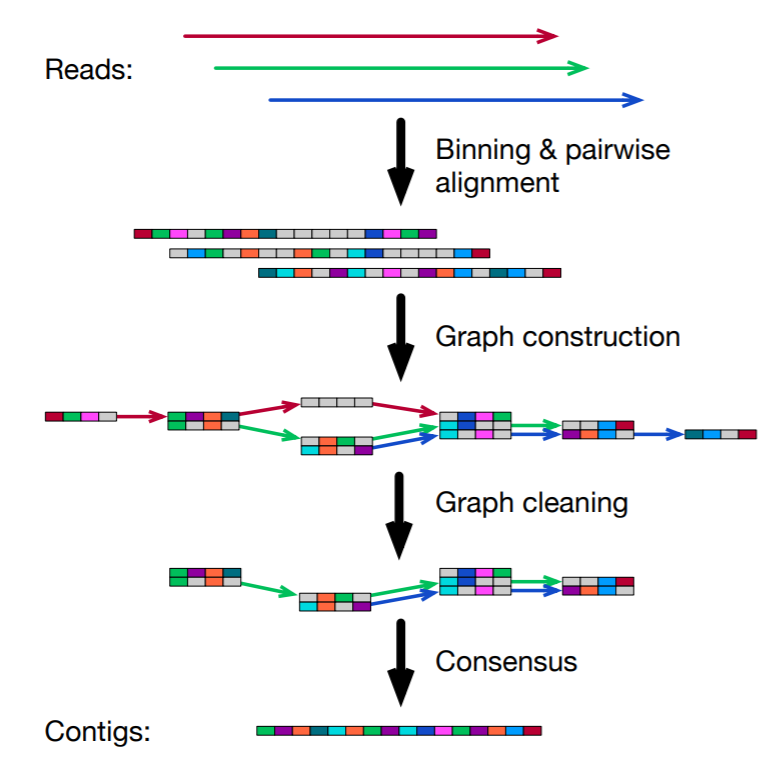

During assembly, wtdbg2 chops reads into 1024bp segments, merges similar segments into a vertex and connects vertices based on the segment adjacency on reads. The resulting graph is called fuzzy Bruijn graph (FBG). It is akin to De Bruijn graph but permits mismatches/gaps and keeps read paths when collapsing k-mers. The use of FBG distinguishes wtdbg2 from the majority of long-read assemblers.

I have installed wtdbg2 on HPCC under: 
`/mnt/research/HRT891_f19/bin/wtdbg2/`

If we run `~/wtdbg2 --help` in terminal we get the following info: 

    WTDBG: De novo assembler for long noisy sequences
    Author: Jue Ruan <ruanjue@gmail.com>
    Version: 2.5 (20190621)
    Usage: wtdbg2 [options] -i <reads.fa> -o <prefix> [reads.fa ...]
    Options:
     -i <string> Long reads sequences file (REQUIRED; can be multiple), []
     -o <string> Prefix of output files (REQUIRED), []
     -t <int>    Number of threads, 0 for all cores, [4]
     -f          Force to overwrite output files
     -x <string> Presets, comma delimited, []
            preset1/rsII/rs: -p 21 -S 4 -s 0.05 -L 5000
                        preset2: -p 0 -k 15 -AS 2 -s 0.05 -L 5000
                        preset3: -p 19 -AS 2 -s 0.05 -L 5000
                  sequel/sq
               nanopore/ont:
            (genome size < 1G: preset2) -p 0 -k 15 -AS 2 -s 0.05 -L 5000
            (genome size >= 1G: preset3) -p 19 -AS 2 -s 0.05 -L 5000
          preset4/corrected/ccs: -p 21 -k 0 -AS 4 -K 0.05 -s 0.5
     -g <number> Approximate genome size (k/m/g suffix allowed) [0]
     -X <float>  Choose the best <float> depth from input reads(effective with -g) [50.0]
     -L <int>    Choose the longest subread and drop reads shorter than <int> (5000 recommended for PacBio) [0]
                 Negative integer indicate tidying read names too, e.g. -5000.
     -k <int>    Kmer fsize, 0 <= k <= 23, [0]
     -p <int>    Kmer psize, 0 <= p <= 23, [21]
                 k + p <= 25, seed is <k-mer>+<p-homopolymer-compressed>
     -K <float>  Filter high frequency kmers, maybe repetitive, [1000.05]
                 >= 1000 and indexing >= (1 - 0.05) * total_kmers_count
     -S <float>  Subsampling kmers, 1/(<-S>) kmers are indexed, [4.00]
                 -S is very useful in saving memeory and speeding up
                 please note that subsampling kmers will have less matched length
     -l <float>  Min length of alignment, [2048]
     -m <float>  Min matched length by kmer matching, [200]
     -R          Enable realignment mode
     -A          Keep contained reads during alignment
     -s <float>  Min similarity, calculated by kmer matched length / aligned length, [0.05]
     -e <int>    Min read depth of a valid edge, [3]
     -q          Quiet
     -v          Verbose (can be multiple)
     -V          Print version information and then exit
     --help      Show more options`


There is a lot to unpack here, but for our first assembly, we only need to set a few parameters and provide a few files: <br>
`-i` this is the file containing the raw long read sequences. For all of our unknown genomes, we will be using raw PacBio reads. These will be located under `/mnt/research/HRT891_f19/Week_1_Genome_assembly/00_raw_PacBio_data/` <br>
Each set of raw PacBio sequences will have the prefix: `Unknown_raw_PacBio_X.fasta` and represent sequences from a different plant or algae species. <br>
<br>
`-o` Sets the output prefix and directory of where the assembly files will go. We can set this to two places: your home directory `/mnt/home/MSU_net_ID` or `/mnt/scratch/MSU_net_ID`. Putting files in /scratch is preferable since you have _virtually_ unlimited space. The downside is files are automatically removed from /scratch after 30 days, so any important files you want to keep should be removed before then. <br>
<br>
`-t` Sets the number of threads or processors to use. Using more processors speeds up the job somewhat (but not always) proportionally, but jobs requesting more processors tend to take longer to launch in the queuing system. We will shoot for 12 in this case. <br>
<br>
`-x` Sets presets for graph construction and read utilization based on the seuqencing technology that was used (PacBio or Nanopore). Our data will be relatively old (~2-3 year) PacBio data, so we will set it as `-x rs`<br>
<br>
`-g` Sets the approximate genome size of the organism. Our unknown species will have relatively small genomes ranging from 14-50 Mb, so we can set it as  20 megabases or `-g 20m`<br>
<br>
We will leave all other parameters as default, but these can be optimized. 

Because wtdbg2 has low memory and CPU requirements, and we're assembling relatively small genomes, we can run this job on a developmental node (instead of submitting it to the queueing system via Slurm). There are several ways to access a developmental node, but the simplest is to use the HPCC module `powertools` to randomly assign us to a node without too many processes running. <br>
First, we need to load the module `powertools` as follows. Powertools has lots of useful utilities, but we will use `dev`

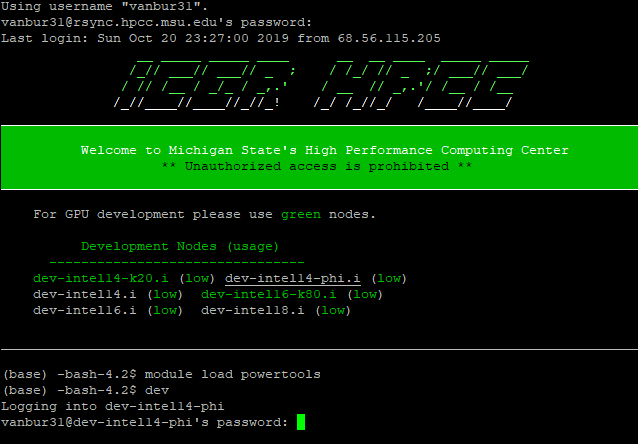

This will log us into a developmental node to run wtdbg2. 

We can run the following example command to launch the assembly on a developmental node on hpcc. **Note: remember to change the directories to your correct path:**<br>
<br>
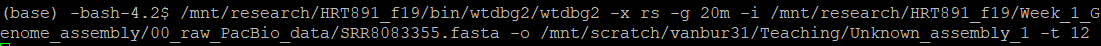

Now that the assembly has finished, we need to turn the contig layout into actual sequences. We do this using `./wtpoa-cns` with the following command: 
<br>
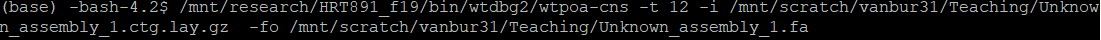

Where:
<br>
`-i` Sets the path for the inmput contig layout file showing how contigs are arranged in the assembly graph. <br>
<br>
`-t` Sets the number of threads or processors to use. Again, using more processors speeds up the job somewhat (but not always) proportionally, but jobs requesting more processors tend to take longer to launch in the queuing system. We will shoot for 12 in this case. <br>
<br>
`-fo` Sets the output path of the final assembly file. This is the file we ultimately care about  <br>
<br>

## Putting it all together

Now that we have our genome, it’s time to figure out what it is! Although, ideally you would know the species before you sequenced it... There are circumstances where you might not know the species though, such as microbiome metagenomics, pathology, forensics, etc. 
<br>
There are several ways to do this, but the simplest is to align our sequences against a database of known sequences and return the best matches. There are  several tools that can do this and for simplicity, we will use BLAST. We will explore tools that can handle genome-scale alignments in later notebooks. For this exercise you will need to import the assembly (after downloading it to your local computer from HPCC), pull out a single or a few contigs, and use BLAST to figure out what species was sequenced. 

In [18]:
## Use SeqIO.read to read the assembly file
from Bio import SeqIO

unknown_dict = SeqIO.to_dict(SeqIO.parse("test3.raw.fa", "fasta"))
#print(len(unknown_dict))
#print(unknown_dict.keys())
single_unknown_contig = unknown_dict["ctg600"]
SeqIO.write(single_unknown_contig, "ctg600.fa", "fasta")

1

In [19]:
## Use SeqIO.write to pull out a subset of fasta sequences for BLAST
from Bio.Blast import NCBIWWW
query = SeqIO.read("ctg600.fa", format="fasta")
result_handle = NCBIWWW.qblast("blastn", "nt", query.seq, format_type="Text")

In [20]:
## BLAST to figure out species
with open("my_blast.txt", "w") as save_to:
    save_to.write(result_handle.read())
    result_handle.close()
myfile = open("my_blast.txt")
for line in myfile:
    print(line)
myfile.close()

<p><!--

QBlastInfoBegin

	Status=READY

QBlastInfoEnd

--><p>

<PRE>

BLASTN 2.10.0+

Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro

A. Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and

David J. Lipman (1997), "Gapped BLAST and PSI-BLAST: a new

generation of protein database search programs", Nucleic

Acids Res. 25:3389-3402.





RID: VEBHMA12014





Database: Nucleotide collection (nt)

           56,840,973 sequences; 256,848,598,563 total letters

Query= 

Length=7529





                                                                   Score     E     Max

Sequences producing significant alignments:                       (Bits)  Value  Ident



CP031036.1 Chloropicon primus strain CCMP1205 chromosome 3, co...  12317   0.0    97%         

XM_019773227.1 PREDICTED: Branchiostoma belcheri uncharacteriz...  100     1e-15  71%         

CP012672.1 Sorangium cellulosum strain So ce836 chromosome, co...  96.9    1e-14  71%         

CP013244.1 Caulobacteraceae b


>CP007155.1 Kutzneria albida DSM 43870, complete genome

Length=9874926



 Score = 80.6 bits (88),  Expect = 1e-09

 Identities = 83/109 (76%), Gaps = 0/109 (0%)

 Strand=Plus/Plus



Query  4771    CGCCCGCGGACTCGCCGAAAATCGTGACCTTGGATGGATCCGCGCCAAACTGCTCGATGT  4830

               ||||||| |||| ||||   | ||||| |      || ||| |||| |||| | ||||||

Sbjct  522652  CGCCCGCCGACTGGCCGCCGACCGTGATCGCCCCCGGGTCCCCGCCGAACTCCGCGATGT  522711



Query  4831    TCTCCTGCACCCACCGCAGCGCCGCGATCTGATCAAACAAGCCAAAGTT  4879

               |||| |||||||| ||||||||||||||||| || | ||  || |||||

Sbjct  522712  TCTCGTGCACCCAGCGCAGCGCCGCGATCTGGTCCAGCAGCCCGAAGTT  522760





 Score = 70.7 bits (77),  Expect = 2e-06

 Identities = 67/86 (78%), Gaps = 0/86 (0%)

 Strand=Plus/Minus



Query  4770     CCGCCCGCGGACTCGCCGAAAATCGTGACCTTGGATGGATCCGCGCCAAACTGCTCGATG  4829

                || ||| ||||||||||||| | |||||| |||   || ||| |||| ||   | |||||

Sbjct  4939282  CCACCCCCGGACTCGCCGAACACCGTGACGTTGCGCGGGTCCCCGCCGAAACCCGCGATG  49

What is the GC content of your species? 

In [21]:
## Answer
from Bio.SeqUtils import GC
GC(query)

AttributeError: 'SeqRecord' object has no attribute 'count'

How many contigs are in your assembly? Do you think this is a good assembly? 

In [ ]:
## Answer

What species did you sequence? Does it match 100% If not, why do you think that is? 

In [ ]:
## Answer

**BONUS:** Make a histogram of the distribution of contig lengths in the assembly

In [ ]:
## Answer

## BONUS 2x: Assembing genomes using Canu
Wtdgb2 is lousy at assembling most plant genomes (in my experience). This may be due to the assembly approach (fuzzy de Brujin graph vs consensus overlap) or some other factor. The program that consistently provides the highest quality assemblies is Canu. I have installed Canu on hpcc under `/mnt/research/HRT891_f19/bin/canu-1.8/` and it is run similarly to wtdgb2. Canu is more CPU and memory intensive though, so it can't be run quickly on a developmental node. 
<br> Instead, we must submit the job to the queue via the Slurm workload manager. An example submission script can be found under: `/mnt/research/HRT891_f19/Week_1_Genome_assembly/Canu_scripts/Canu_example.sb`
<br> 
We need to provide the following information: 
<br>
<br>
`-d` Sets the directory to output assembly files. Canu generates A LOT of intermediate files, so if you don't have a lot of space, it's probably best to output it in `/scratch`
<br>
<br>
`-p` Sets the file output names. Ideally this inlclude be the species name and some other identifiers. 
<br>
<br>
`genomesize=` Sets the genome size in megabases (m) or gigabases (g). For example, a 1Gb genome could be set as 1000m or 1g
<br>
<br>
`-pacbio-raw` Specifies the type of data (raw or polished, nanopore or PacBio) and sets the path to the data for assembly. 
<br>
<br>
**Note: There is an art to submitting jobs on HPCC and having them start quickly. I would recommnd changing the number of CPUs or nodes as well as memory requirements to try and get the job to run more quickly. 

<br>
We will discuss the outputs from Canu on the next class period (Monday) and visualize the assembly quality using graphs like the one below! Note, this assembly graph is from a complex allo-octaploid species (8 copies of the genome), so it is quite complex!

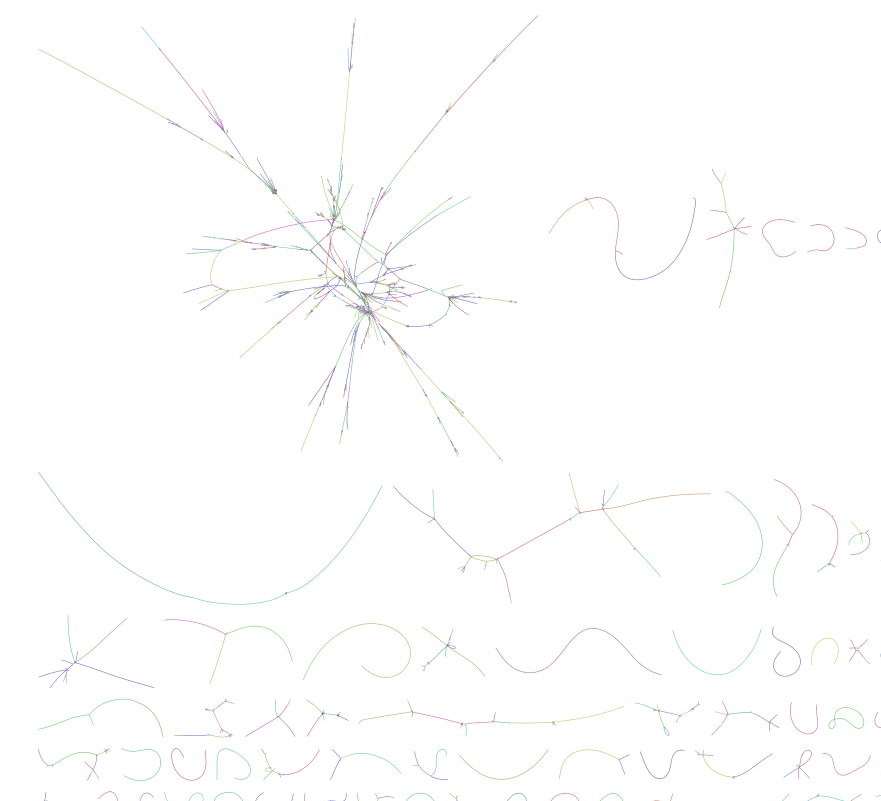

___